### Import Libraries

In [1]:
# Ignore cuDDa warning messages
import warnings
import os
warnings.filterwarnings('ignore')

# Enable GPU
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# # Expands the Jupyter Notebook Output Size to fit your window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Load in tensorboard
%load_ext tensorboard

# Change the working directory back to the original to keep paths the same between files
os.chdir(r'C:\Users\Maxwell\PycharmProjects\TAMU-ECEN-403-IFPTSND\ECEN_403_IFM\TAMU-ECEN-403-IFPTSND')

import datetime
import pickle
import sys
from os.path import join, isfile
import shutil

import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow import keras
import tensorflow.keras.backend as kb
from tensorflow.python.ops import math_ops
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras import Sequential

from explore_entities import Graph_Entities
import ipywidgets as widgets
from ipywidgets import Layout, GridBox
from IPython.display import display
import matplotlib.pyplot as plt

import warnings
import os
import math

from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

### Allows for scrolling windows to be very large

In [2]:
%%javascript
    IPython.OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

### Import TF_models and truncate the entities to only contain 880 companies

In [3]:
from tensorflow_models import TF_Models, Ein_Multiply, leaky_relu, rank_loss_func
DMJ = TF_Models('./ignorable_data/data_sets/NASDAQ_Cleaned - Contains ZUMZ/', './ignorable_data/models/[55, 25, 20]_split/', reload=False)
data_splits = DMJ.split_data()

DMJ.Normalized_Adjacency_Matrix = DMJ.Normalized_Adjacency_Matrix[0:880, 0:880]
DMJ.XX_tf = DMJ.XX_tf[0:-1, :, :]
DMJ.YY_tf = DMJ.YY_tf[0:-1, :]
DMJ.RR_tf = DMJ.RR_tf[0:-1, :]
DMJ.entities = DMJ.entities[0:-1]
DMJ.entities_idx.pop('ZUMZ')

model = DMJ.generate_model()

from graph_predictions import Graph_Predictions
GP = Graph_Predictions("./ignorable_data/models/[55, 25, 20]_split/", "./ignorable_data/strategies/RL_validation_strategies/", 'x_val', DMJ)

GridBox(children=(Dropdown(description='Model Types:', options=('lstm', 'lstm_gcn_1', 'lstm_gcn_2', 'lstm_gcn_…

# What if we split the data into time batches ourselves and trained them?

In [4]:
# Given a total and list of splits, evenly distributes the total amount proportional to the given list
def split_windows(total, percentages_list):
    # Get a sum of the initial total
    percentage_sum = sum(percentages_list)

    # Create a new list based on a percentage of the total
    new_splits = []
    for perc in percentages_list:
        new_splits.append(int(total * (perc / percentage_sum)))
    
    # Where to shift the extra days that don't exactly divide between the values
    if sum(new_splits) != total:
        new_splits[-1] = new_splits[-1] + (total - sum(new_splits))

    return new_splits

# one_x = DMJ.XX_tf[0:2, :, :]
# one_y = DMJ.YY_tf[0:2, :]
one_x = DMJ.XX_tf
print(DMJ.XX_tf.shape)
one_y = DMJ.YY_tf

# one_x = DMJ.XX_tf[0:-1, :, :]
# one_y = DMJ.YY_tf[0:-1, :]

# # Given a dataset, let's section off a fifth of the data to be used for testing purposes
# time_split = [1000, 239,]
# x_train, x_test = tf.split(one_x, split_windows(one_x.shape[1], time_split),
#                                   axis=1)
# y_train, y_test = tf.split(one_y, split_windows(one_y.shape[1], time_split),
#                                   axis=1)
# rr_train, rr_test = tf.split(DMJ.RR_tf, split_windows(one_y.shape[1], time_split),
#                                      axis=1)

# Given a dataset, let's section off a fifth of the data to be used for testing purposes
time_split = [90, 710, 239, 199]
time_split = [55, 25, 20]

time_split = [30, 25, 25, 20]
x_g, x_train, x_val, x_test = tf.split(one_x, split_windows(one_x.shape[1], time_split),
                                  axis=1)
y_g, y_train, y_val, y_test = tf.split(one_y, split_windows(one_y.shape[1], time_split),
                                  axis=1)
rr_g, rr_train, rr_val, rr_test = tf.split(DMJ.RR_tf, split_windows(one_y.shape[1], time_split),
                                     axis=1)

# y_train = y_train[:, -1]
# y_val = y_val[:, -1]

# # Once we have the data partitioned, let's split it into 8 sets of 125
# batch_splits = [1]*8
# # Create a list of 8 different time batches
# x_train_batches = []
# x_train_batches.append(tf.split(x_train, split_windows(x_train.shape[1], batch_splits), axis=1))
# x_train_batches = [item for sublist in x_train_batches for item in sublist]

# y_train_batches = []
# y_train_batches.append(tf.split(y_train, split_windows(x_train.shape[1], batch_splits), axis=1))
# y_train_batches = [item for sublist in y_train_batches for item in sublist]

# # Lets try truncating the values for the labels to only be the final value
# for i in range(len(y_train_batches)):
#     y_train_batches[i] = y_train_batches[i][:, -1]

# print(x_train[0, -1, 0])

# print(rr_train[0, -1])

# print(x_val[0, 0, 0])
# print(y_train[0, -1])
# for set in [x_train, x_g, x_val, x_test]:
print(x_val.shape)
print(x_train.shape)

print(x_train[0, 0, 0])
print(x_train[0, 1, 0])
print(rr_train[0, 0])

print(x_train[0, -1, 0])
print(x_train[0, -2, 0])
print(x_train[0, -2:-1, 0])

print(keras.Input(shape=(x_train.shape[1], x_train.shape[2])).shape)

(880, 1239, 5)
(880, 309, 5)
(880, 309, 5)
tf.Tensor(0.455917, shape=(), dtype=float32)
tf.Tensor(0.461538, shape=(), dtype=float32)
tf.Tensor(0.012328968, shape=(), dtype=float32)
tf.Tensor(0.425614, shape=(), dtype=float32)
tf.Tensor(0.415741, shape=(), dtype=float32)
tf.Tensor([0.415741], shape=(1,), dtype=float32)
(None, 309, 5)


### Let's create the one-hot encoded adjacency matrix to work with

In [5]:
import explore_entities
# Load in the code
GE = Graph_Entities('./ignorable_data/data_sets/NASDAQ_Cleaned - Contains ZUMZ - Yuning/')
# Generate the baseline components we're wokring with
NAM, Adj, Rel = GE.get_matrix_components()

GridBox(children=(Text(value='Loading Normalized Adjacency Matrix:', disabled=True, layout=Layout(width='auto'…

GridBox(children=(Text(value='Loading Normalized Adjacency Matrix:', disabled=True, layout=Layout(width='auto'…

### Let's check the dimensionality of normalized adjacency matrix we have so far 

In [6]:
# Checks to see if a matrix is normalized among it's rows and columns to 6 decimal places
def is_normalized(m):
    m_t = np.transpose(m)
    r_trigger = True
    c_trigger = True
    for i in m:
        if (round(np.sum(i), 6)) != 1 and r_trigger:
            print('Rows Not Normalized')
            r_trigger = not r_trigger
    for i in m_t:
        if (round(np.sum(i), 6)) != 1 and c_trigger:
            print('Columns Not Normalized')
            c_trigger = not c_trigger
    
    if r_trigger and c_trigger:
        print('Normalized')
        return True
    else:
        return False

# Created with D^-1/2 * A * D^-1/2
print(f"Symetrically Normalized DMJ: {NAM.shape}")
is_normalized(NAM)
print("####")
# All relationships, but still seperated by the different groups
print(f"One-Hot Encoded Relationships Split by Group: {Rel.shape}")
print("####")
# All relationships squished into one matrix
print(f"One-Hot Encoded All Relationships: {Adj.shape}")
is_normalized(Adj)
print("####")

None

print(np.sum(Rel[9, :, :])/2)

Symetrically Normalized DMJ: (881, 881)
Normalized
####
One-Hot Encoded Relationships Split by Group: (92, 881, 881)
####
One-Hot Encoded All Relationships: (881, 881)
Rows Not Normalized
Columns Not Normalized
####
12.5


### Split the training data

In [7]:
# Given a total and list of splits, evenly distributes the total amount proportional to the given list
def split_windows(total, percentages_list):
    # Get a sum of the initial total
    percentage_sum = sum(percentages_list)

    # Create a new list based on a percentage of the total
    new_splits = []
    for perc in percentages_list:
        new_splits.append(int(total * (perc / percentage_sum)))
    
    # Where to shift the extra days that don't exactly divide between the values
    if sum(new_splits) != total:
        new_splits[-1] = new_splits[-1] + (total - sum(new_splits))

    return new_splits

one_x = DMJ.XX_tf
one_y = DMJ.YY_tf

time_split = [90, 710, 239, 199]
time_split = [55, 25, 20]

time_split = [30, 25, 25, 20]
x_g, x_train, x_val, x_test = tf.split(one_x, split_windows(one_x.shape[1], time_split),
                                  axis=1)
y_g, y_train, y_val, y_test = tf.split(one_y, split_windows(one_y.shape[1], time_split),
                                  axis=1)
rr_g, rr_train, rr_val, rr_test = tf.split(DMJ.RR_tf, split_windows(one_y.shape[1], time_split),
                                     axis=1)

# Loading in an already trained LSTM model & Adding Topographical Layer

In [127]:
from tensorflow_models import mse_rr
from tensorflow_models import rank_loss_rr
tf.random.set_seed(1337)

optimizer = tf.keras.optimizers.Adam(
            learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
            name='Adam'
        )

# Create a function for the Tensorflow implementation of leaky_relu
def leaky_relu(x):
    return tf.keras.layers.LeakyReLU(alpha=0.2)(x)

def normalize_adj_matrix(adj):
    degree = tf.experimental.numpy.sum(adj, axis=0)
    inv = lambda x: x**-1
    inv_degree = inv(degree)
    diag_inv_degree = np.diag(inv_degree)
    return np.dot(diag_inv_degree, adj)

hidden_units = 64
activation = leaky_relu
do = 0

# Assuming all time steps are the same size, we can just use the first item to determine input shape
# For the time-series data
input_seq = keras.Input(shape=(x_train.shape[1], x_train.shape[2]))


# For the Adjacency Matrix we would like to introduce to the algorithm
adj_matrix = Adj

# Since some implementations removed the last company
if adj_matrix.shape[0] == 881:
    adj_matrix = adj_matrix[0:-1, 0:-1]

input_rel = keras.Input(shape=(adj_matrix.shape[0]))


# Load in an already trained LSTM Model
file_name = '2-20-21-1_LSTM_[25,25,20]_NoDropout_100Epoch_80BatchSize_1000ALPHA'
model_path = './ignorable_data/models/[55, 25, 20]_split/'
pre_trained_lstm = tf.keras.models.load_model(model_path + f'{file_name}', compile=False,
                                              custom_objects={'leaky_relu': leaky_relu})

# Change the names to avoid conflicts
pre_trained_lstm.layers[0]._name = 'Original-InputLayer'
pre_trained_lstm.layers[1]._name = 'Original-LSTM'
pre_trained_lstm.layers[2]._name = 'Original-Dense'

# # Make sure that the weights for the lstm model cannot be updated
pre_trained_lstm.layers[0].trainable = False
pre_trained_lstm.layers[1].trainable = False
pre_trained_lstm.layers[2].trainable = False

# This is the LSTM layer, input_seq is not carried over from the original because we don't care how it was initalized
x = pre_trained_lstm.layers[1](input_seq)

# This is a seperate input layer that will take in the relational matrix
y = tf.keras.layers.Dense(adj_matrix.shape[0], activation)(input_rel)
y = normalize_adj_matrix(y)

# # This is one aggregation using the NAM
x = Ein_Multiply()([y, x])
# x = Dense(hidden_units, activation=activation)(x)

# This is the original Dense Layer
x = pre_trained_lstm.layers[2](x)

# This is a new Dense layer we might want to experiment with
# x = Dense(1, activation=activation)(x)

model = tf.keras.Model(inputs=[input_seq, input_rel], outputs=x)

losses = []

AttributeError: module 'tensorflow._api.v2.experimental' has no attribute 'numpy'

In [ ]:
# View what we just created
# model.compile(loss=rank_loss_rr, optimizer=optimizer)
model.compile(loss='mse', optimizer=optimizer)
model.summary()

Epoch 1/100
1/1 [==============================] - 1s 537ms/step - loss: 0.2869 - val_loss: 0.1850
Epoch 2/100
1/1 [==============================] - 0s 459ms/step - loss: 0.2205 - val_loss: 0.1849
Epoch 3/100
1/1 [==============================] - 0s 424ms/step - loss: 0.1922 - val_loss: 0.1852
Epoch 4/100
1/1 [==============================] - 0s 463ms/step - loss: 0.2836 - val_loss: 0.1853
Epoch 5/100
1/1 [==============================] - 0s 420ms/step - loss: 0.1986 - val_loss: 0.1855
Epoch 6/100
1/1 [==============================] - 0s 425ms/step - loss: 0.1628 - val_loss: 0.1857
Epoch 7/100
1/1 [==============================] - 0s 489ms/step - loss: 0.1818 - val_loss: 0.1860
Epoch 8/100
1/1 [==============================] - 0s 419ms/step - loss: 0.2143 - val_loss: 0.1864
Epoch 9/100
1/1 [==============================] - 0s 422ms/step - loss: 0.1917 - val_loss: 0.1869
Epoch 10/100
1/1 [==============================] - 0s 423ms/step - loss: 0.2006 - val_loss: 0.1872
Epoch 11/

1/1 [==============================] - 1s 564ms/step - loss: 0.2352 - val_loss: 0.1973
Epoch 84/100
1/1 [==============================] - 0s 494ms/step - loss: 0.1542 - val_loss: 0.1977
Epoch 85/100
1/1 [==============================] - 0s 419ms/step - loss: 0.1267 - val_loss: 0.1981
Epoch 86/100
1/1 [==============================] - 0s 434ms/step - loss: 0.1599 - val_loss: 0.1982
Epoch 87/100
1/1 [==============================] - 1s 669ms/step - loss: 0.1672 - val_loss: 0.1985
Epoch 88/100
1/1 [==============================] - 1s 599ms/step - loss: 0.3185 - val_loss: 0.1981
Epoch 89/100
1/1 [==============================] - 0s 489ms/step - loss: 0.1869 - val_loss: 0.1979
Epoch 90/100
1/1 [==============================] - 0s 432ms/step - loss: 0.1642 - val_loss: 0.1976
Epoch 91/100
1/1 [==============================] - 0s 481ms/step - loss: 0.1673 - val_loss: 0.1972
Epoch 92/100
1/1 [==============================] - 0s 439ms/step - loss: 0.1547 - val_loss: 0.1967
Epoch 93/100


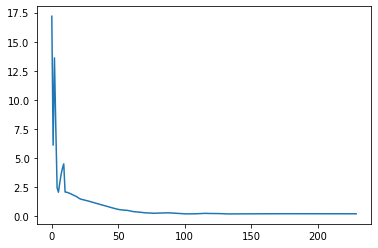

In [66]:
tf.config.run_functions_eagerly(True)

checkpoint_filepath = './tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            save_best_only=True)

def scheduler(epoch, lr):
    return 0.000005

inputs_train = [x_train]
train_labels = y_train

inputs_val = [x_val]
val_labels = y_val

# If we're using the GCN
inputs_train.append(adj_matrix)
inputs_val.append(adj_matrix)

# int(inputs_train.shape[0])

history = model.fit(inputs_train, train_labels, batch_size=int(inputs_train[0].shape[0]),
                              epochs=100, validation_data=(inputs_val, val_labels),
                   callbacks=[model_checkpoint_callback,
                             tf.keras.callbacks.LearningRateScheduler(scheduler,
                                                                      verbose=0)])

model.load_weights(checkpoint_filepath)

for h in history.history['val_loss']:
    losses.append(h)
plt.plot(losses)

In [ ]:
# model.predict([x_train, DMJ.Normalized_Adjacency_Matrix], batch_size=880)
model_save = model

In [ ]:
# for h in history.history['val_loss']:
#     losses.append(h)
# plt.plot(losses)

DMJ.Normalized_Adjacency_Matrix.shape

In [67]:
DMJ.model = model
DMJ.model_name = "3-15-21-1_LSTM_[25,25,20]_100Epoch_881BatchSize_TFMSE_881Dense-X-SquishAdj_TrainableFinalDense"
DMJ.save_model()

'None--0Epochs-None-Loss-None-HU-'

In [68]:
# model_name = "2-16-21-Seq1LSTM-F-64HU-[800,239,200]split-full_y"
# new_directory = './ignorable_data/prediction_results/[55, 25, 20]_splits/'
# GP.generate_validation_prediction_json_SplitBatch_nofeat(model_name, new_directory, x_g, x_val, sliding_window=30)
# GP.generate_validation_prediction_json_SplitBatch_close_gap(model_name, new_directory, x_g, x_val, sliding_window=30)
model_name = '3-15-21-1_LSTM_[25,25,20]_100Epoch_881BatchSize_TFMSE_881Dense-X-SquishAdj_TrainableFinalDense'
model_dir = './ignorable_data/models/[55, 25, 20]_split'
# model_dir = 'G:\Shared drives\Max Huffman - ECEN 403 404 URS Research 2020 2021\Datasets\models'
past = x_train
future = x_val
# new_dir = 'G:\Shared drives\Max Huffman - ECEN 403 404 URS Research 2020 2021\Datasets\predictions\pc_version'
new_dir = './ignorable_data/prediction_results/[55, 25, 20]_splits/'
sliding_window = x_val.shape[1]

window = x_train.shape[1]

GP.generate_predictions(model_name, model_dir, past, future, new_dir, window, model_type='gcn', batch_size=881)
# GP.generate_predictions(model_name, model_dir, past, future, new_dir, window, model_type='lstm', batch_size=880)
# GCN_output = GP.return_embeddings(model_name, model_dir, past, future, new_dir, w, model_type='gcn')
# embeddings = GP.return_embeddings(model_name, model_dir, past, future, new_dir, window, model_type='gcn')

#     model_name = '2-20-21-1_LSTM_[25,25,20]_NoDropout_35Epoch_80BatchSize_IncreasedVariedLR_RRMSE'
#     GP.generate_predictions(model_name, model_dir, past, future, new_dir, w)
# GP.generate_validation_prediction_json_SplitBatch(model_name, new_dir, x_g, x_val, sliding_window=sliding_window)


Loading Model: '3-15-21-1_LSTM_[25,25,20]_100Epoch_881BatchSize_TFMSE_881Dense-X-SquishAdj_TrainableFinalDense'
Total number of days: 308
Day 1 | Day 2 | Day 3 | Day 4 | Day 5 | Day 6 | Day 7 | Day 8 | Day 9 | Day 10 | Day 11 | Day 12 | Day 13 | Day 14 | Day 15 | Day 16 | Day 17 | Day 18 | Day 19 | Day 20 | Day 21 | Day 22 | Day 23 | Day 24 | Day 25 | Day 26 | Day 27 | Day 28 | Day 29 | Day 30 | Day 31 | Day 32 | Day 33 | Day 34 | Day 35 | Day 36 | Day 37 | Day 38 | Day 39 | Day 40 | Day 41 | Day 42 | Day 43 | Day 44 | Day 45 | Day 46 | Day 47 | Day 48 | Day 49 | Day 50 | Day 51 | Day 52 | Day 53 | Day 54 | Day 55 | Day 56 | Day 57 | Day 58 | Day 59 | Day 60 | Day 61 | Day 62 | Day 63 | Day 64 | Day 65 | Day 66 | Day 67 | Day 68 | Day 69 | Day 70 | Day 71 | Day 72 | Day 73 | Day 74 | Day 75 | Day 76 | Day 77 | Day 78 | Day 79 | Day 80 | Day 81 | Day 82 | Day 83 | Day 84 | Day 85 | Day 86 | Day 87 | Day 88 | Day 89 | Day 90 | Day 91 | Day 92 | Day 93 | Day 94 | Day 95 | Day 96 | Day 97

In [ ]:
# Given the training set, these are the validation values that are output from the LSTM model
print(embeddings.shape)

# This is the NAM that we are using to aggregate the embedding results
print(DMJ.Normalized_Adjacency_Matrix[6,6])

# This should be the aggregated values output from using the NAM (The dimensions look fine)
# new_embeddings = tf.einsum('ntd,nm->mtd', embeddings, DMJ.Normalized_Adjacency_Matrix)
new_embeddings = tf.einsum('mn,ntd->mtd', DMJ.Normalized_Adjacency_Matrix, embeddings)
print(new_embeddings.shape)

print(embeddings[0, -7, 0:10])
# print(embeddings[0, -1, 0:10])
print('  ')
print(new_embeddings[0, -7, 0:10])
# print(new_embeddings[0, -1, 0:10])

# print(tf.subtract(embeddings[0, -2, 0:10], embeddings[0, -1, 0:10]))
# print(tf.subtract(new_embeddings[0, -2, 0:10], new_embeddings[0, -1, 0:10]))

In [ ]:
# Above are the output embeddings of the LSTM layer
# Below is 1 output prediction for a simple NAM Aggregate added to a pre-trained LSTM
GCN_output.shape

In [69]:
p_file_name = '3-15-21-1_LSTM_[25,25,20]_100Epoch_881BatchSize_TFMSE_881Dense-X-SquishAdj_TrainableFinalDense309win_309past_309fut'
p_file_dir = '.\ignorable_data\prediction_results\[55, 25, 20]_splits'
# p_file_dir = 'G:\Shared drives\Max Huffman - ECEN 403 404 URS Research 2020 2021\Datasets\predictions\pc_version'
future = x_val
new_dir = './ignorable_data/datablocks/[55, 25, 20]_splits/'
close_gap = False

use_argmin = False
yesterday_pred = False
GP.generate_prediction_results(p_file_name, p_file_dir, future, new_dir, close_gap=close_gap, use_argmin=use_argmin, yesterday_pred=yesterday_pred, rr_labels=True)

for root, dirs, files in os.walk(r'C:\Users\Maxwell\PycharmProjects\TAMU-ECEN-403-IFPTSND\ECEN_403_IFM\TAMU-ECEN-403-IFPTSND\ignorable_data\datablocks\[55, 25, 20]_splits'):
    for filename in files:
#         GP.generate_prediction_results(filename, p_file_dir, future, new_dir, close_gap=close_gap, use_argmin=use_argmin, yesterday_pred=yesterday_pred)
        GP.add_daily_value_to_datablock(filename, './ignorable_data/datablocks/[55, 25, 20]_splits')
        GP.add_daily_value_to_datablock_discontinuous(filename, './ignorable_data/datablocks/[55, 25, 20]_splits')
        GP.add_cumulative_return_ratio_discontinuous(filename, './ignorable_data/datablocks/[55, 25, 20]_splits')
        None


# use_argmin = True
# yesterday_pred = False
# GP.generate_prediction_results(p_file_name, p_file_dir, future, new_dir, close_gap=close_gap, use_argmin=use_argmin, yesterday_pred=yesterday_pred)
# # GP.generate_model_diagnostics_given_sets(p_file_dir + f'/{p_file_name}', future, datablock_folder=new_dir, try_all_pred=False)

CSWC


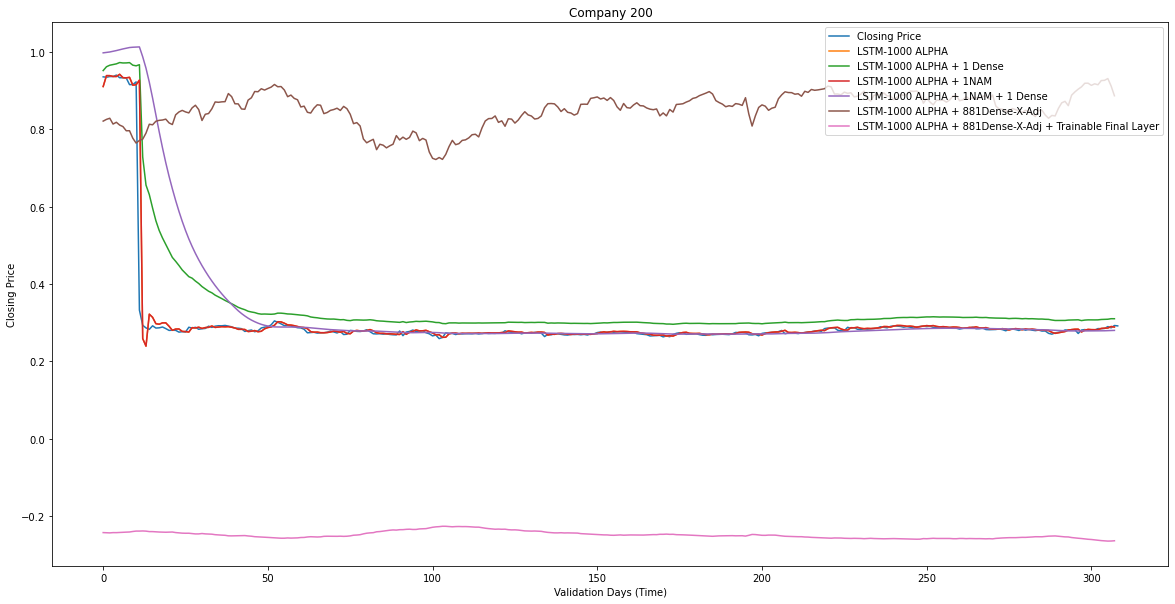

In [74]:
# n = 597
# n = 488
# n = 161
# n = 561
# n = 440
n = 200
# # Argmin
# n = 780

# n = 876
# n = 110
r = 1
# n = 100
# n=0

fig, ax = plt.subplots(figsize=(20, 10))
# ax.set_ylim([0,1])

time = tf.concat([x_train, x_val, x_test], axis=1)

# ax = fig.add_subplot()
for i in range(r):
#     print(f'{i+n*r} ', end='')
#     ax.plot(time[i+n*r, :, 0])
    ax.plot(x_val[i+n*r, :, 0], label='Closing Price')
#     ax.plot(rr_val[i+n*r, :], label='Return Ratio')
    
    ax.plot(A[:, i+n*r], label='LSTM-1000 ALPHA')
    ax.plot(B[:, i+n*r], label='LSTM-1000 ALPHA + 1 Dense')
    ax.plot(C[:, i+n*r], label='LSTM-1000 ALPHA + 1NAM')
    ax.plot(D[:, i+n*r], label='LSTM-1000 ALPHA + 1NAM + 1 Dense')
    ax.plot(E[:, i+n*r], label='LSTM-1000 ALPHA + 881Dense-X-Adj')
    ax.plot(F[:, i+n*r], label='LSTM-1000 ALPHA + 881Dense-X-Adj + Trainable Final Layer')

    ax.legend()
    ax.set_xlabel('Validation Days (Time)')
    ax.set_ylabel('Closing Price')
    ax.set_title(f'Company {i+n*r}')
# Orange
# Green
# Red
# Purple
# Brown

print(DMJ.entities[n])

In [70]:
pred_dir = '.\ignorable_data\prediction_results\[55, 25, 20]_splits/'
pred_file = '2-20-21-1_LSTM_[25,25,20]Reloaded_1000ALPHA309win_309past_309fut'
GP.graph_model_prediction_given_sets(pred_dir + pred_file, x_val)
A = GP.test_obj

pred_dir = '.\ignorable_data\prediction_results\[55, 25, 20]_splits/'
pred_file = '3-12-21-1_LSTM_[25,25,20]_10Epoch_880BatchSize_TFMSE_Additional_64_Dense_Layer309win_309past_309fut'
GP.graph_model_prediction_given_sets(pred_dir + pred_file, x_val)
B = GP.test_obj

pred_file = '2-20-21-1_LSTM_[25,25,20]_NoDropout_100Epoch_80BatchSize_1000ALPHA_1NAMAGGREGATE309win_309past_309fut'
GP.graph_model_prediction_given_sets(pred_dir + pred_file, x_val)
C = GP.test_obj

pred_file = '2-20-21-1_LSTM_[25,25,20]_NoDropout_100Epoch_80BatchSize_1000ALPHA_1DenseGCN_TFMSE_FullTrain309win_309past_309fut'
GP.graph_model_prediction_given_sets(pred_dir + pred_file, x_val)
D = GP.test_obj

pred_file = '3-15-21-1_LSTM_[25,25,20]_650Epoch_881BatchSize_TFMSE_881Dense-X-SquishAdj309win_309past_309fut'
GP.graph_model_prediction_given_sets(pred_dir + pred_file, x_val)
E = GP.test_obj

pred_file = '3-15-21-1_LSTM_[25,25,20]_100Epoch_881BatchSize_TFMSE_881Dense-X-SquishAdj_TrainableFinalDense309win_309past_309fut'
GP.graph_model_prediction_given_sets(pred_dir + pred_file, x_val)
F = GP.test_obj

# pred_file = '02-17-2021--07--20-1LSTM-F-0ALPHA-[55,25,20]split-[None, 1]-40Epochs-rlf-Loss-64-HU-30win_681past_309fut'
# GP.graph_model_prediction_given_sets(pred_dir + pred_file, x_val)
# G = GP.test_obj

# pred_file = '02-17-2021--07--20-1LSTM-F-0ALPHA-[55,25,20]split-[None, 1]-40Epochs-rlf-Loss-64-HU-60win_681past_309fut'
# GP.graph_model_prediction_given_sets(pred_dir + pred_file, x_val)
# H = GP.test_obj

# pred_file = '02-17-2021--07--20-1LSTM-F-0ALPHA-[55,25,20]split-[None, 1]-40Epochs-rlf-Loss-64-HU-125win_681past_309fut'
# GP.graph_model_prediction_given_sets(pred_dir + pred_file, x_val)
# I = GP.test_obj

# pred_file = '02-17-2021--07--20-1LSTM-F-0ALPHA-[55,25,20]split-[None, 1]-40Epochs-rlf-Loss-64-HU-250win_681past_309fut'
# GP.graph_model_prediction_given_sets(pred_dir + pred_file, x_val)
# J = GP.test_obj

# pred_file = '02-17-2021--07--20-1LSTM-F-0ALPHA-[55,25,20]split-[None, 1]-40Epochs-rlf-Loss-64-HU-500win_681past_309fut'
# GP.graph_model_prediction_given_sets(pred_dir + pred_file, x_val)
# K = GP.test_obj

Have Predictions
Have Predictions
Have Predictions
Have Predictions
Have Predictions
Have Predictions


In [ ]:
GP.compare_data_blocks('.\ignorable_data\datablocks\[55, 25, 20]_splits')

In [ ]:
# # pred_dir = r"G:\Shared drives\Max Huffman - ECEN 403 404 URS Research 2020 2021\Datasets\predictions/"
# pred_dir = r".\ignorable_data\prediction_results\[55, 25, 20]_splits/"
# pred_file = '3-11-21-1_LSTM_[25,25,20]_60Epoch_40BatchSize_100ALPHA_RR_Labels309win_309past_309fut_220predBatch'
# GP.generate_model_diagnostics(pred_dir + pred_file, datablock_folder='./ignorable_data/datablocks/', rr_labels=True)
# # GP.generate_model_diagnostics_given_sets_close_gap(pred_dir + pred_file, x_val, datablock_folder='./ignorable_data/datablocks/', try_all_pred=False)

In [ ]:
import json
# Let's look at our relations_file real quick
with open('./ignorable_data/data_sets/NASDAQ_Cleaned - Contains ZUMZ/updated_relations.json') as read_file:
    relations_dict = json.load(read_file)

In [120]:
# The degree vector of Adj
degree = np.sum(Adj, axis=0)

# Inverse degree vector
inv = lambda x: x**-1
inv_degree = inv(degree)

# Convert into an inverse diagonal matrix
diag_inv_degree = np.diag(inv_degree)

# Create the negative square root version
inv_sqrt_degree = np.sqrt(inv_degree)

diag_inv_sqrt_degree = np.diag(inv_sqrt_degree)

In [121]:
# Symetric normalization yields the correct output
print(np.sum(np.dot(np.dot(inv_sqrt_degree, Adj), inv_sqrt_degree)))

881.0


In [122]:
# The last company, ZUMF was truncated in this example, so this value makes sense.
print(np.sum(DMJ.Normalized_Adjacency_Matrix))

879.125


In [123]:
# Standard normalization yields the correct output
print(np.sum(np.dot(diag_inv_degree, Adj)))

881.0
